# Bigram Language Modeling using frequency counts for generating Onion-like News Headlines

Based on Andrej Karpathy's first half Youtube lecture [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re, string
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path


import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

## Functions

In [2]:
def plot_bigram_counts(ax, bigram_counts, vocab):
  itos = {i:s for i,s in enumerate(vocab)}  
  ax.imshow(bigram_counts, cmap='Blues')
  for i in range(len(stoi)):
    for j in range(len(stoi)):
      chstr = f'{itos[i]}{itos[j]}'
      ax.text(j, i, chstr, ha='center', va='bottom', color='gray')
      ax.text(j, i, bigram_counts[i,j].item(), ha='center', va='top', color='gray')
  ax.axis('off')  

## Data Setup

In [3]:
try:
  onion_df = pd.read_csv('../data/cleaned_onion_headlines.csv')
except FileNotFoundError:
  onion_df = pd.read_csv('../data/original_onion_headlines.csv')

  onion_df['text'] = onion_df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
  onion_df['text'] = onion_df['text'].apply(str.lower)

  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub(r'\$([0-9]+)', '\g<1> dollars', t))

  from num2words import num2words
  def convert_nums(text):
    nums = re.findall(r'\d+', text)
    converts = {num: num2words(num).replace('-', ' ') for num in nums}
    for num,word in converts.items():
      text = text.replace(num, word)
    return text
  onion_df['text'] = onion_df['text'].apply(convert_nums)

  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub(r'[^a-z ]', '', t))
  onion_df['text'].replace('', np.nan, inplace=True)
  onion_df.dropna(inplace=True)
  onion_df.to_csv('../data/cleaned_onion_headlines.csv', index=None)
onion_df.shape

(14362, 1)

In [4]:
onion_df['length'] = onion_df['text'].apply(len)
onion_df['length'].describe()

count    14362.000000
mean        78.609525
std         30.916162
min          3.000000
25%         57.000000
50%         76.000000
75%         96.000000
max        312.000000
Name: length, dtype: float64

In [5]:
idx = 0
text = onion_df.iloc[idx]['text']
print(text)

entire facebook staff laughs as man tightens privacy settings


In [6]:
idx = np.random.randint(len(onion_df))
text = onion_df.iloc[idx]['text']
print(text)

grossedout antiabortion activist has change of heart after seeing picture of fetus for first time


## Bigram Language Model

In [7]:
texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
print(len(vocab))
vocab

28


['#',
 ' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [8]:
bigram_counts = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
for text in texts:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    bigram_counts[idx1, idx2] += 1    

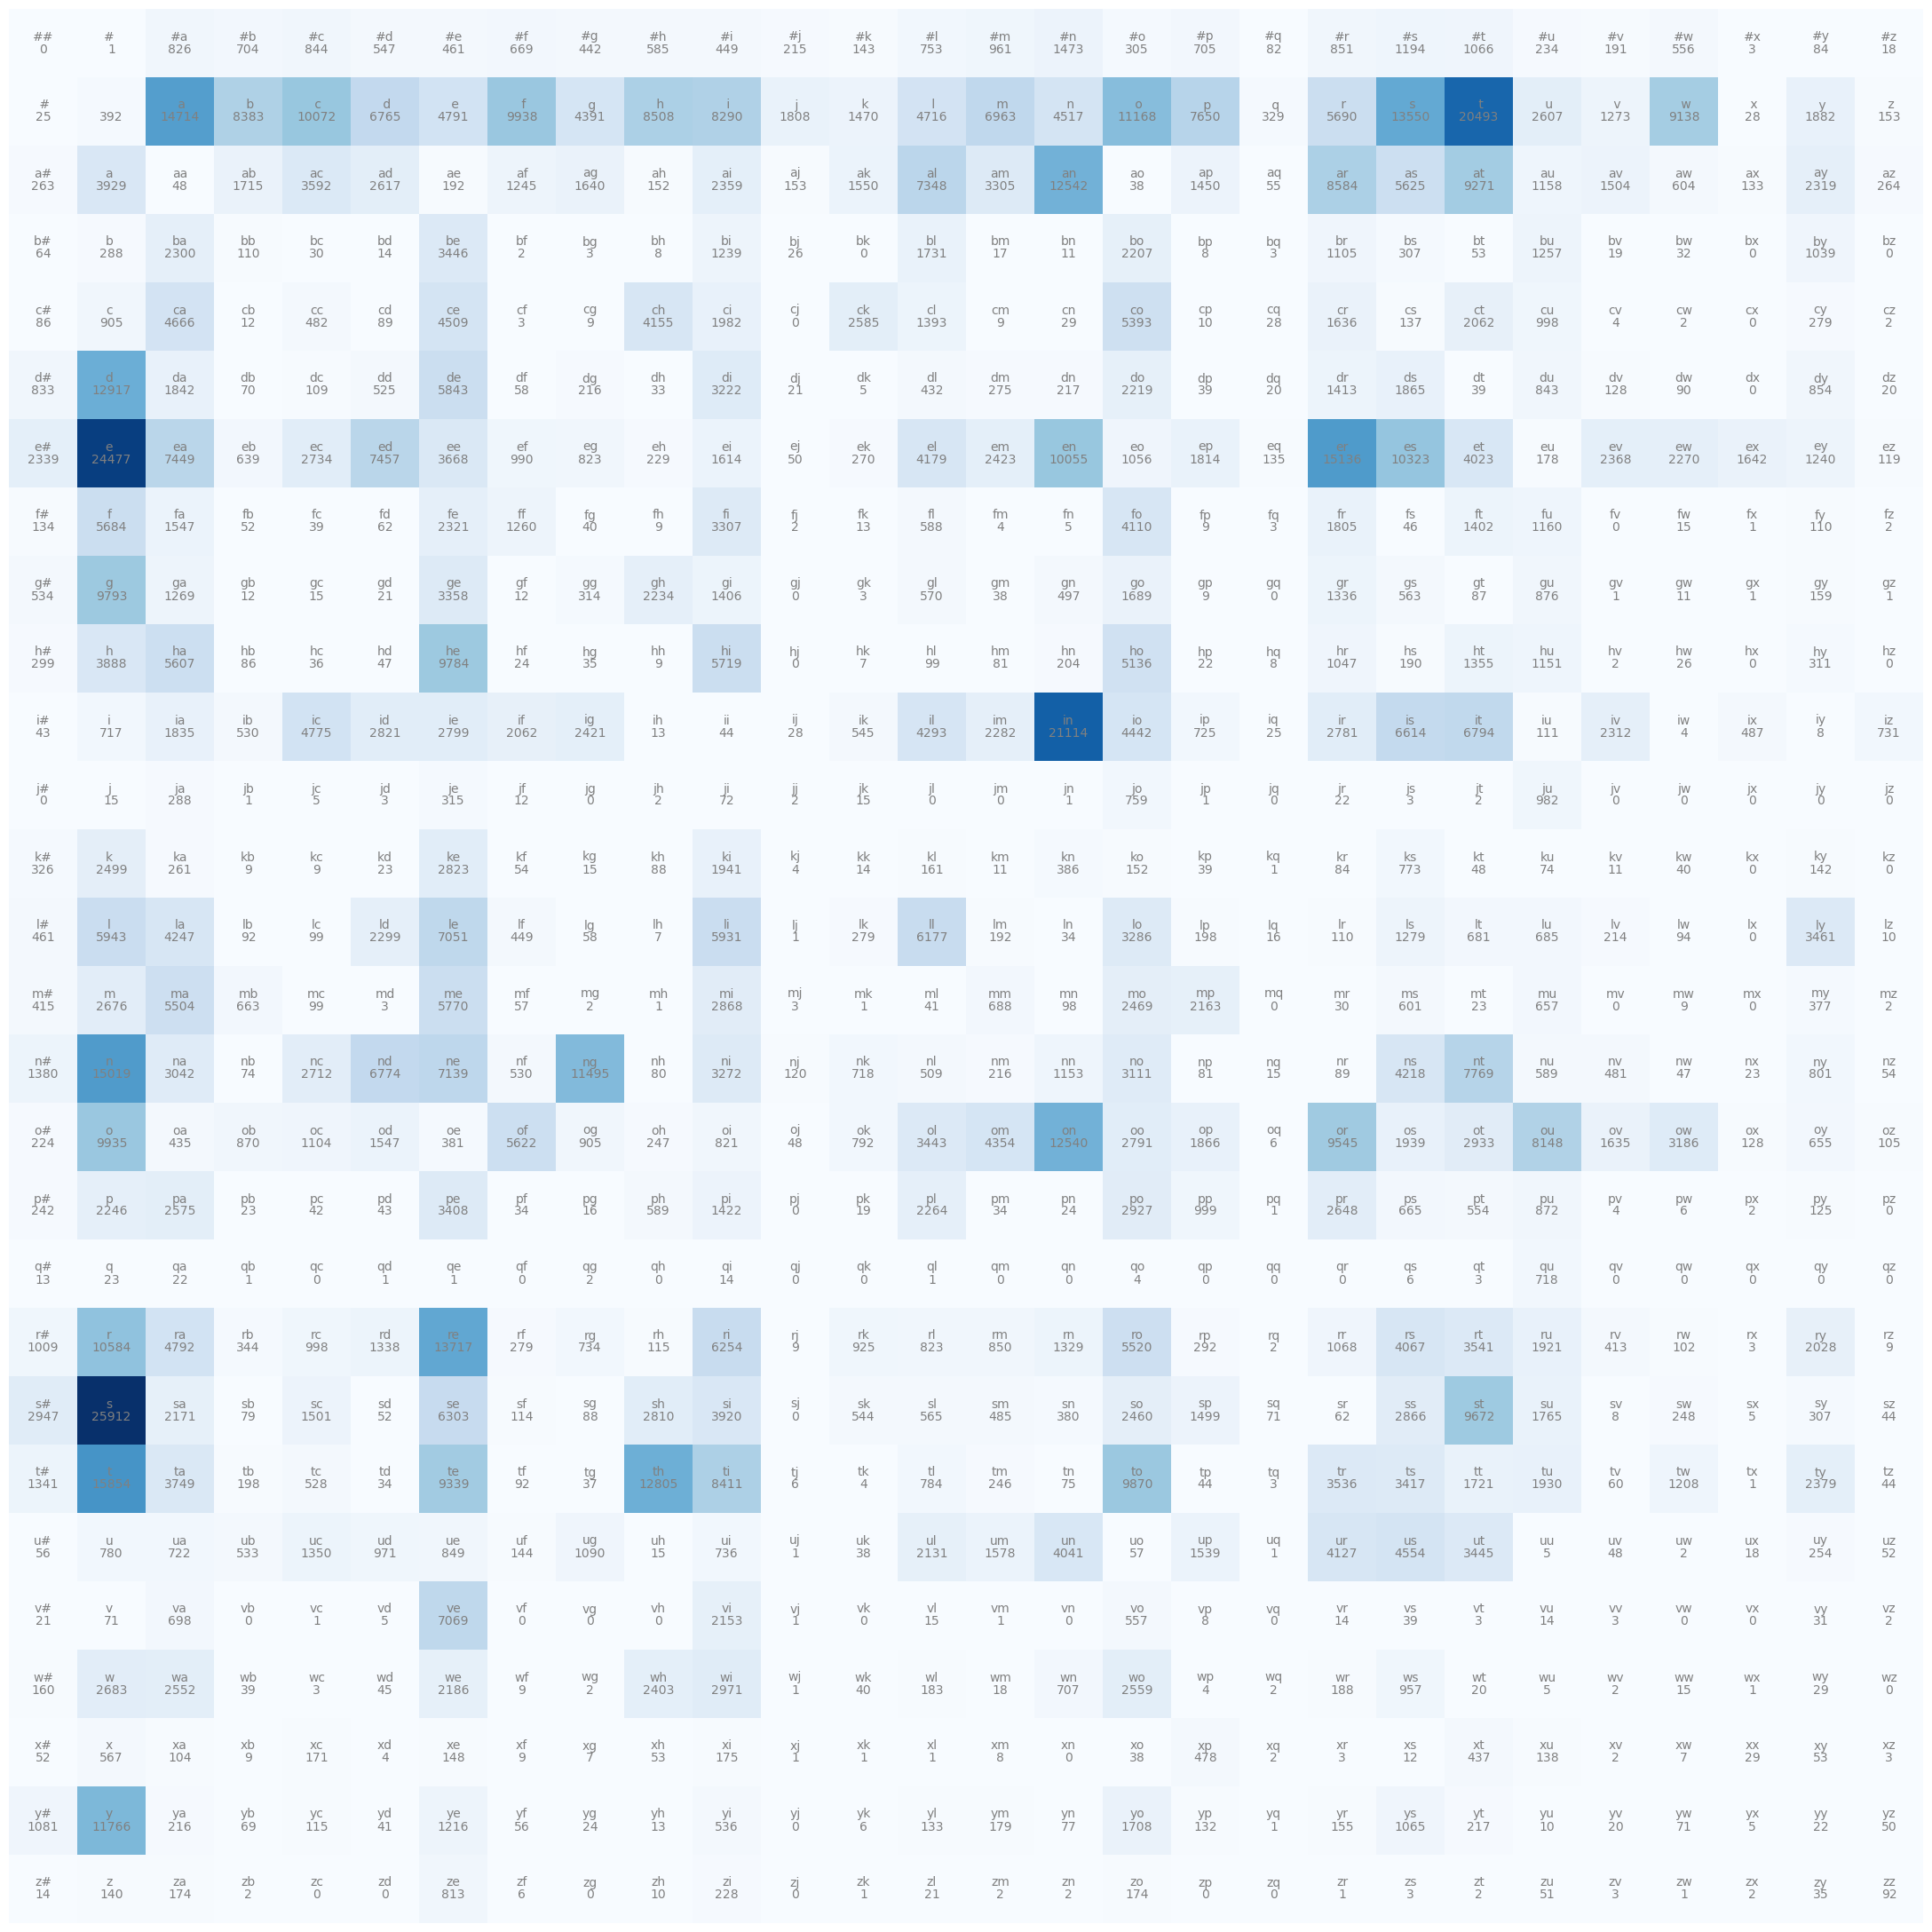

In [9]:
fig, ax = plt.subplots(1,1,figsize=(len(vocab),len(vocab)))
plot_bigram_counts(ax, bigram_counts, vocab)

In [10]:
bigram_counts[0]

tensor([   0,    1,  826,  704,  844,  547,  461,  669,  442,  585,  449,  215,
         143,  753,  961, 1473,  305,  705,   82,  851, 1194, 1066,  234,  191,
         556,    3,   84,   18], dtype=torch.int32)

In [11]:
p = bigram_counts[0].float()/bigram_counts[0].sum()
p

tensor([0.0000e+00, 6.9628e-05, 5.7513e-02, 4.9018e-02, 5.8766e-02, 3.8087e-02,
        3.2099e-02, 4.6581e-02, 3.0776e-02, 4.0732e-02, 3.1263e-02, 1.4970e-02,
        9.9568e-03, 5.2430e-02, 6.6913e-02, 1.0256e-01, 2.1237e-02, 4.9088e-02,
        5.7095e-03, 5.9254e-02, 8.3136e-02, 7.4224e-02, 1.6293e-02, 1.3299e-02,
        3.8713e-02, 2.0888e-04, 5.8488e-03, 1.2533e-03])

In [12]:
bigram_probs = bigram_counts.float()/bigram_counts.sum(axis=1, keepdim=True)

In [13]:
bigram_probs[0] == p

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [14]:
g = torch.Generator().manual_seed(2468975301)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

's'

In [15]:
g = torch.Generator().manual_seed(2468975301)
n_headlines = 20
for _ in range(n_headlines):
  idx = 0
  ai_onion = []
  while True:
    idx = torch.multinomial(bigram_probs[idx], num_samples=1, replacement=True, generator=g).item()
    # idx = torch.multinomial(torch.ones(len(vocab))/len(vocab), num_samples=1, replacement=True, generator=g).item()
    ai_onion.append(itos[idx])
    if idx == 0:
      break
  print(''.join(ai_onion[:-1]))    

sthag crifousesiteamur anul angharmpetarincerarery upldicenet anctisu arco dizo ty spes lm dakepp s s comen me ie iplanousceetolllemit me tbola orer be caimow gce den bse s d m
fotasboun cos b hay te h d fetowmpo andsintinancandn alelyoompg
s r f cexxcl p cegid tern tty dviecly kn mas tistingre eershed s ine m d tacen ithefosphtilofrik wsanduneratecang ca conns thed
ne med tiny us hintivesamapeabur forer
bsiofed mid cr
hus caudy f ere fo s ditsidah upbitoun hertysteyst ome
novils ws higaurerngy piry tidvio ha alonlstilleins
bean
r gertoco ficreax llingedesaphel a babin athect
panco d sctws on on lsthatan t o e roued brs uthopren at lo binie incofi re jeghommamimbucke atom e h eatstye
encond pale in co cistits id peshere tes ffow ewinofay mioknelichoph vese
pouchablod k jolepin ap pller ts mebuameanary ppap t sunsat tay hontocryifoxtheveatowathemal s s fomintee
mifr r ointhed cheereve tirsal brkumissepa sss s con peshunshllifoin w woor thosople sammace ulo vinist taly flllan
ledes plyif

GOAL: Maximize the liklihood of the data w.r.t model parameters (statistical modeling). This is equivalent to:
1. maximizing the log liklihood (because log is monotonic)
2. minimizing the negative log liklihood
3. minimizing the average negative logliklihood

In [16]:
log_likelihood = 0.
n = 0
for text in texts:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    prob = bigram_probs[idx1, idx2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{ch1}{ch2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {-log_likelihood/n:0.4f}")

log_likelihood=tensor(-2849655.7500)
nll=tensor(2849655.7500)
average nll 2.4924


In [17]:
cnn_headline = 'Trump goes to Supreme Court over Mar a Lago search and seizure of documents'.lower()
onion_headline = 'High Schoolers Given Detention For Cutting Class During Active Shooting'.lower()

In [18]:
log_likelihood = 0.
n = 0
for text in [cnn_headline]:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    prob = bigram_probs[idx1, idx2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{ch1}{ch2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {-log_likelihood/n:0.4f}")

log_likelihood=tensor(-193.4804)
nll=tensor(193.4804)
average nll 2.5458
